<a href="https://colab.research.google.com/github/patriciamedyna/Classifier_page/blob/main/Tobacco800_with_tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 187 kB 4.3 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 


In [2]:
#hide
!pip install -Uqq fastbook
import fastbook

     |████████████████████████████████| 720 kB 4.4 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 1.2 MB 69.0 MB/s 
     |████████████████████████████████| 51 kB 358 kB/s 
     |████████████████████████████████| 561 kB 71.1 MB/s 
     |████████████████████████████████| 130 kB 83.2 MB/s 


In [3]:
#hide
from fastbook import *
from IPython.display import display,HTML

In [4]:
from fastai.basics import *
from fastai.text.core import *
from fastai.text.data import *
from fastai.text.models.core import *
from fastai.text.models.awdlstm import *
from fastai.callback.rnn import *
from fastai.callback.progress import *
from fastai.vision import *
from fastai.text.all import *
from fastai.text import *
from datetime import datetime

In [5]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Tobacco_LSTM/layout/'
#path = '/content/drive/.shortcut-targets-by-id/1R_vnrbg04zsdpye6d-dv190eSUWCL07i/Tobacco_LSTM/layout/'

In [46]:
df_train = pd.read_csv(path + 'train_tags.csv', delimiter=',',  error_bad_lines=False, index_col=False)
df_train = df_train.drop(['text'], axis=1)
df_train.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,binder,docid,class,text_tags
0,Tobacco800,aah97e00-page02_1,FirstPage,"['\n', 'xxQ00_01 xxbob \n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_01 xxbob PHILIP MORRIS\n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_01 xxbob EUROPE MIDDLE EAST AFRICA\n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_01 xxbob RESEARCH AND DEVELOPMENT\n', 'xxeob xxQ01_02\n', '\n', 'xxQ01_02 xxbob Neuchatel, duly 14, 1977\n', 'xxeob xxQ01_03\n', '\n', 'xxQ01_01 xxbob Dr. M.A. Manzelli,\n', 'PHILIP MORRIS INC.,\n', 'Research Center,\n', 'P.O. Box 3 D\n', 'Richmond, Va. 23206\n', 'U.S.A. .\n', 'xxeob xxQ02_01\n', '\n', 'xxQ02_01 xxbob Dear Art,\n', 'xxeob xxQ02_01\n', '\n', 'xxQ03_01 xxbob xxbcet Please proposed pro..."
1,Tobacco800,aah97e00-page02_2,NextPage,"['\n', 'xxQ00_00 xxbob Please let krow if you have any changes for the proposed\n', 'me\n', 'program.\n', 'xxeob xxQ01_03\n', '\n', 'xxQ01_00 xxbob Looking forward to seeing you again,\n', 'xxeob xxQ01_02\n', '\n', 'xxQ01_02 xxbob Yours very truly,\n', '_.\n', 'xxeob xxQ01_03\n', '\n', 'xxQ01_02 xxbob xxbcet \n', 'xxecet\n', 'xxeob xxQ02_03\n', '\n', 'xxQ02_02 xxbob .B. Boder\n', 'xxeob xxQ02_03\n', '\n', 'xxQ02_00 xxbob cc: Messrs. B. Kuhn\n', 'xxbcet E. Stoop\n', 'xxecet\n', 'xxeob xxQ02_01\n', '\n', 'xxQ02_00 xxbob Encl.: mentioned\n', 'xxeob xxQ03_01\n', '\n', 'xxQ04_01 xxbob we\n',..."


In [48]:
df_train = df_train.drop(columns=['docid','binder'])
df_train.head(2)

,class,text_tags
0,FirstPage,"['\n', 'xxQ00_01 xxbob \n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_01 xxbob PHILIP MORRIS\n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_01 xxbob EUROPE MIDDLE EAST AFRICA\n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_01 xxbob RESEARCH AND DEVELOPMENT\n', 'xxeob xxQ01_02\n', '\n', 'xxQ01_02 xxbob Neuchatel, duly 14, 1977\n', 'xxeob xxQ01_03\n', '\n', 'xxQ01_01 xxbob Dr. M.A. Manzelli,\n', 'PHILIP MORRIS INC.,\n', 'Research Center,\n', 'P.O. Box 3 D\n', 'Richmond, Va. 23206\n', 'U.S.A. .\n', 'xxeob xxQ02_01\n', '\n', 'xxQ02_01 xxbob Dear Art,\n', 'xxeob xxQ02_01\n', '\n', 'xxQ03_01 xxbob xxbcet Please proposed pro..."
1,NextPage,"['\n', 'xxQ00_00 xxbob Please let krow if you have any changes for the proposed\n', 'me\n', 'program.\n', 'xxeob xxQ01_03\n', '\n', 'xxQ01_00 xxbob Looking forward to seeing you again,\n', 'xxeob xxQ01_02\n', '\n', 'xxQ01_02 xxbob Yours very truly,\n', '_.\n', 'xxeob xxQ01_03\n', '\n', 'xxQ01_02 xxbob xxbcet \n', 'xxecet\n', 'xxeob xxQ02_03\n', '\n', 'xxQ02_02 xxbob .B. Boder\n', 'xxeob xxQ02_03\n', '\n', 'xxQ02_00 xxbob cc: Messrs. B. Kuhn\n', 'xxbcet E. Stoop\n', 'xxecet\n', 'xxeob xxQ02_01\n', '\n', 'xxQ02_00 xxbob Encl.: mentioned\n', 'xxeob xxQ03_01\n', '\n', 'xxQ04_01 xxbob we\n',..."


In [8]:
df_test = pd.read_csv(path + 'test_tags.csv', delimiter=',', error_bad_lines=False)
df_test = df_test.drop(['text'], axis=1)
df_test.head(1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,binder,docid,class,text_tags
0,Tobacco800,tkj51f00_1,FirstPage,"['\n', 'xxQ00_01 xxbob \n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_01 xxbob h Department\n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_00 xxbob MARCH 26, 1986\n', 'FILE NOTL\n', 'xxeob xxQ00_03\n', '\n', 'xxQ00_02 xxbob \n', 'xxeob xxQ00_03\n', '\n', 'xxQ00_02 xxbob Pare}\n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_00 xxbob COMPONERTS/415_& St\n', 'MATLLARD REACTION “Al! FLAVOR\n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_02 xxbob Fisgert, af Grove AG GALLON Toe lo. 1\n', 'xxeob xxQ00_03\n', '\n', 'xxQ00_00 xxbob the layer of the Mailiare\n', 'Jdentification of flavor components in aqueous\n', 'this communicati..."


In [47]:
df_test = df_test.drop(columns=['docid','binder'])
#df_test = data.drop(columns= 'binder')
#unsup = df_test.drop(columns='class')
#unsup.head(2)
df_test.head(1)

,class,text_tags
0,FirstPage,"['\n', 'xxQ00_01 xxbob \n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_01 xxbob h Department\n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_00 xxbob MARCH 26, 1986\n', 'FILE NOTL\n', 'xxeob xxQ00_03\n', '\n', 'xxQ00_02 xxbob \n', 'xxeob xxQ00_03\n', '\n', 'xxQ00_02 xxbob Pare}\n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_00 xxbob COMPONERTS/415_& St\n', 'MATLLARD REACTION “Al! FLAVOR\n', 'xxeob xxQ00_02\n', '\n', 'xxQ00_02 xxbob Fisgert, af Grove AG GALLON Toe lo. 1\n', 'xxeob xxQ00_03\n', '\n', 'xxQ00_00 xxbob the layer of the Mailiare\n', 'Jdentification of flavor components in aqueous\n', 'this communicati..."


## Create DataLoader

In [49]:
def get_features(r):

  return r['text']

def get_labels(r):

  return r['class']

In [50]:
df_train.keys()

Index(['class', 'text_tags'], dtype='object')

In [51]:
dblock_train = DataBlock(
    blocks=(TextBlock.from_df(text_cols=['text_tags', 'class'], seq_len=72), CategoryBlock),
            get_x=get_features, 
            get_y=get_labels)

dloader_train = dblock_train.dataloaders(df_train, bs=128)
dloader_train.show_batch(max_n=2)

,text,category
0,"xxbos xxfld 1 [ ' \n ' , ' xxq00_00 xxbob \n ' , ' xxeob xxq00_00 \n ' , ' \n ' , ' xxq00_00 xxbob xxbcet - \n ' , ' xxecet \n ' , ' xxunk \n ' , ' xxeob xxq00_00 \n ' , ' \n ' , ' xxq00_00 xxbob \n ' , ' xxeob xxq00_00 \n ' , ' \n ' , ' xxq00_00 xxbob \n ' , ' xxeob xxq00_01 \n ' , ' \n ' , ' xxq00_00 xxbob xxbcet xxmaj the | end xxmaj xxunk t xxmaj content xxmaj of xxmaj one xxmaj hundred \n ' , ' xxecet \n ' , ' xxeob xxq00_01 \n ' , ' \n ' , ' xxq00_00 xxbob \n ' , ' xxeob xxq00_01 \n ' , ' \n ' , ' xxq00_00 xxbob xxbcet \n ' , ' xxecet \n ' , '",NextPage
1,"xxbos xxfld 1 [ ' \n ' , ' xxq00_00 xxbob xxup lo xxmaj absorbance xxmaj unit xxmaj full xxmaj seale \n ' , ' at 550 xxmaj dm \n ' , ' "" po xxup la xxmaj xxunk xxunk xxunk xxmaj abi xxup xxunk \ ' xxup ant xxrep 3 a xxmaj dy \n ' , ' xxeob xxq00_01 \n ' , ' \n ' , ' xxq00_00 xxbob [ ge \n ' , ' xxbcet om xxmaj xxunk ia xxunk xxmaj xxunk ni \n ' , ' xxecet \n ' , ' pre xxunk xxmaj tet xxup tm ce xxup ct xxup tt xxup tt nat \n ' , ' he s xxmaj fee et xxrep 3 t xxrep 3 t xxrep 3 t xxup tt at en \n ' , ' ei i \n ' , ' foes xxunk xxup ce at xxunk xxup tt xxup tt",NextPage


## Classification Model

In [52]:
# checkpoint 
cbs=[SaveModelCallback()]

In [53]:
now = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

In [54]:
learn = text_classifier_learner(dloader_train, 
                                AWD_LSTM, 
                                drop_mult=0.5, path='/content/drive/MyDrive/Colab Notebooks/Datasets/Tobacco_LSTM/layout/checkpoints', 
                                metrics=[error_rate, accuracy, Perplexity()]).to_fp16()

In [55]:
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.700475,0.640905,0.393204,0.606796,1.898198,00:06


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.583446,0.646391,0.388350,0.611650,1.908639,00:13
1,0.536884,0.618716,0.315534,0.684466,1.856543,00:13
2,0.497571,0.602451,0.296117,0.703883,1.826591,00:13
3,0.464319,0.584893,0.262136,0.737864,1.794799,00:13


In [56]:
learn.show_results()

,text,category,category_
0,"xxbos xxfld 1 [ ' \n ' , ' xxq00_00 xxbob xxbcet 2202 \n ' , ' xxecet \n ' , ' xxeob xxq00_00 \n ' , ' \n ' , ' xxq00_00 xxbob \n ' , ' xxeob xxq00_01 \n ' , ' \n ' , ' xxq00_00 xxbob ¢ \n ' , ' xxeob xxq00_00 \n ' , ' \n ' , ' xxq00_00 xxbob { b ) xxmaj whether each applicant has \n ' , ' xxunk leaders of that group . \n ' , ' 2 xxmaj to determine with respect to the \n ' , ' » efforts of xxup po to ascertain the needs of \n ' , ' its proposed service area : \n ' , ' ( a ) xxmaj whether the xxunk ! xxunk \n ' , ' leaders of agriculture and ! xxunk in \n ' , ' xxunk ,",NextPage,FirstPage
1,"xxbos xxfld 1 [ ' \n ' , ' xxq00_00 xxbob “ wlrk rightfax xxmaj server 5 / 28 / 99 \n ' , ' xxeob xxq00_01 \n ' , ' \n ' , ' xxq00_01 xxbob 5:12 : xxup page xxunk / 6 \n ' , ' xxeob xxq00_02 \n ' , ' \n ' , ' xxq00_00 xxbob -1 : xxunk xxmaj wilson company : lorillard xxmaj tobacco xxmaj company \n ' , ' xxeob xxq00_02 \n ' , ' \n ' , ' xxq00_00 xxbob xxup martin xxup xxunk \n ' , ' xxunk 4 . xxup xxunk \n ' , ' theodore xxup gewertz \n ' , ' xxunk xxup w. xxup nussbaum \n ' , ' xxunk xxup d. xxup katcher \n ' , ' douglas 5 . xxup xxunk \n ' , ' steven xxup m , xxup barna \n ' , ' chaim",FirstPage,FirstPage
2,"xxbos xxfld 1 [ ' \n ' , ' xxq00_00 xxbob xxup martin xxup lipton \n ' , ' herbert xxup m , xxup wachtell , \n ' , ' theodore xxup gewertz \n ' , ' xxunk xxup w. xxup nussbaum \n ' , ' richard xxup xxunk xxup katcher \n ' , ' douglas $ . xxup xxunk \n ' , ' steven xxup m. xxup barna \n ' , ' chaim xxup j. xxup fortgang \n ' , ' peter xxup g , xxup canellos \n ' , ' michael xxup w. xxup schwartz \n ' , ' allan xxup a. xxup martin \n ' , ' barry xxup a. xxup bryer \n ' , ' lawrence xxup b , xxup pedowitz \n ' , ' rorert @. xxup mazur \n ' , ' paul xxup xxunk , xxup jr . \n ' , ' peter xxup",FirstPage,FirstPage
3,"xxbos xxfld 1 [ ' \n ' , ' xxq00_00 xxbob & \n ' , ' xxeob xxq00_00 \n ' , ' \n ' , ' xxq00_00 xxbob xxup from xxup wachtel xxup lipton xxup rosen xxup matz \n ' , ' + \n ' , ' xxeob xxq00_01 \n ' , ' \n ' , ' xxq01_00 xxbob xxup martin xxup xxunk , \n ' , ' xxunk xxup h , xxup wachtell \n ' , ' xxbcet xxup xxunk xxup xxunk \n ' , ' xxecet \n ' , ' bernard xxup w. xxup nussbaum \n ' , ' xxbcet xxup xxunk xxmaj ds xxup ratcher \n ' , ' xxecet \n ' , ' douglas 5 , xxunk \n ' , ' xxbcet xxup steven xxup m , xxup xxunk \n ' , ' xxecet \n ' , ' charles xxup t. xxup xxunk \n ' ,",FirstPage,FirstPage
4,"xxbos xxfld 1 [ ' \n ' , ' xxq00_00 xxbob # - xxup wlrk rightfax xxmaj server 5 / 98 \n ' , ' to : ronald xxmaj xxunk \n ' , ' xxeob xxq00_01 \n ' , ' \n ' , ' xxq00_01 xxbob xxunk : xxup page 3 / 4 en qe \n ' , ' xxeob xxq00_03 \n ' , ' \n ' , ' xxq00_01 xxbob xxup wachtell , xxup lipton , xxup rosen & katz \n ' , ' xxeob xxq00_02 \n ' , ' \n ' , ' xxq00_00 xxbob xxbcet xxup martin xxunk \n ' , ' xxecet \n ' , ' herbert xxup m. xxup wachtell \n ' , ' xxunk xxup xxunk , \n ' , ' bernard xxup w , xxup nussbaum \n ' , ' richard © . xxup katcher \n ' , ' douglas 5 . xxunk",FirstPage,FirstPage
5,"xxbos xxfld 1 [ ' \n ' , ' xxq00_00 xxbob xxmaj xxunk xxup lt xxmaj oy \n ' , ' herbert 4 xxup wachtell \n ' , ' theodore xxup gewertz \n ' , ' xxunk xxup w. xxup xxunk \n ' , ' richard o xxup xxunk \n ' , ' douglas 5 . xxup xxunk \n ' , ' xxunk xxup mh , xxup xxunk \n ' , ' xxunk do xxup xxunk \n ' , ' peter € . xxup xxunk \n ' , ' michael xxup w , xxup schwartz \n ' , ' allan & s xxup martin \n ' , ' barry xxup a - bryer \n ' , ' lawrence b xxup pedowitz \n ' , ' robert © . xxup mazur \n ' , ' paul xxup xxunk , dh , \n ' , ' peter xxup c. xxup xxunk \n",NextPage,FirstPage
6,"xxbos xxfld 1 [ ' \n ' , ' xxq00_00 xxbob xxup xxunk \n ' , ' xxeob xxq00_00 \n ' , ' \n ' , ' xxq00_00 xxbob xxup wlrk rightfax xxmaj server xxunk / 00 xxunk : xxup page xxunk / 68 xxunk \n ' , ' e @ \n ' , ' company : \n ' , ' _ \n ' , ' xxeob xxq00_02 \n ' , ' \n ' , ' xxq00_01 xxbob xxup wachtell , xxup lipton , xxup rosen & xxup katz \n ' , ' 

In [57]:
learn.save('model_'+ now)

Path('/content/drive/MyDrive/Colab Notebooks/Datasets/Tobacco_LSTM/layout/checkpoints/models/model_2022-03-30-14:43:21.pth')

In [58]:
# load model
learn = learn.load('model_'+ now)

In [59]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.387260,0.589154,0.257282,0.742718,1.802464,00:13
1,0.328636,0.147704,0.038835,0.961165,1.159169,00:13
2,0.239800,1.066988,0.325243,0.674757,2.906610,00:13
3,0.224356,1.064543,0.189320,0.810680,2.899514,00:13
4,0.204534,0.512410,0.048544,0.951456,1.669310,00:13
5,0.172377,0.437365,0.053398,0.946602,1.548620,00:13
6,0.145693,0.453432,0.038835,0.961165,1.573703,00:13
7,0.123453,0.491208,0.038835,0.961165,1.634289,00:13
8,0.107056,0.493420,0.038835,0.961165,1.637908,00:13
9,0.091450,0.503937,0.038835,0.961165,1.655225,00:13


SuggestedLRs(valley=0.0010000000474974513)

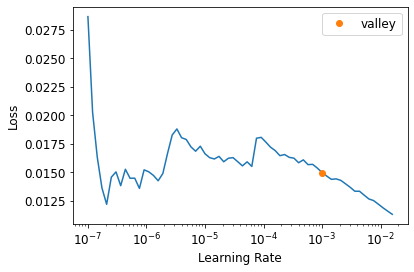

In [60]:
learn.unfreeze()
learn.lr_find()

In [61]:
learn_lm = text_classifier_learner(dloader_train, AWD_LSTM, drop_mult=0.5,path='/content/drive/MyDrive/Colab Notebooks/Datasets/Tobacco_LSTM/layout/checkpoints', 
                                metrics=[error_rate, accuracy, Perplexity()]).to_fp16()

In [62]:
learn_lm.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.676822,0.647516,0.393204,0.606796,1.910788,00:06


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.571357,0.629241,0.378641,0.621359,1.876185,00:13
1,0.542993,0.645148,0.364078,0.635922,1.906269,00:13
2,0.500130,0.690008,0.359223,0.640777,1.993732,00:13
3,0.466884,0.623754,0.286408,0.713592,1.865920,00:13
4,0.439371,0.577185,0.252427,0.747573,1.781018,00:13
5,0.419648,0.523579,0.189320,0.810680,1.688058,00:13
6,0.395648,0.646129,0.228155,0.771845,1.908141,00:13
7,0.373232,0.559417,0.160194,0.839806,1.749652,00:13
8,0.354712,0.529716,0.155340,0.844660,1.698451,00:13
9,0.337379,0.530964,0.160194,0.839806,1.700571,00:13


## Validation

In [63]:
# create dataloader of test
dblock_test_tags = DataBlock(
    blocks=(TextBlock.from_df('text_tags', seq_len=72), CategoryBlock),
            get_x=get_features, 
            get_y=get_labels)

dloader_test = dblock_test_tags.dataloaders(df_test, bs=64)

In [64]:
test_dl = dloader_test.test_dl(df_test['text_tags'])
preds = learn_lm.get_preds(dl=test_dl, with_decoded=True)

In [65]:
len(preds)

3

(#4) [0.5309641361236572,0.16019417345523834,0.8398058414459229,1.700571060180664]

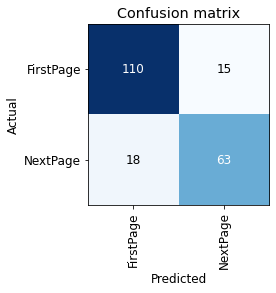

In [66]:
interp = ClassificationInterpretation.from_learner(learn_lm)
interp.plot_confusion_matrix()
learn_lm.validate()

In [67]:
test_dl = dloader_test.test_dl(df_test['text_tags'])
preds = learn.get_preds(dl=test_dl, with_decoded=True)

(#4) [0.5039367079734802,0.03883494809269905,0.9611650705337524,1.6552245616912842]

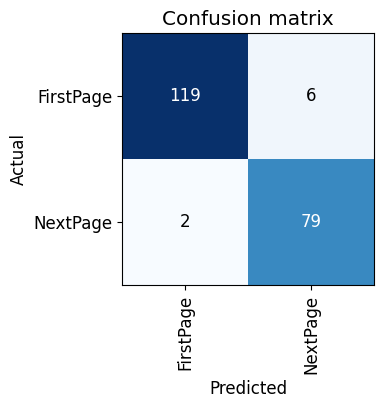

In [68]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=100)
learn.validate()